<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex07/Aula7_Marcus_Vinicius_Borela_de_Castro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = "Marcus Vinicius Borela de Castro"
print(f'Meu nome é {nome}')

Meu nome é Marcus Vinicius Borela de Castro


#  Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural simples para prever a proxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Língua".

Este dataset já possui um tamanho razoável e é bem provável que você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset é bem grande. Não dê comando de imprimí-lo.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

# Preparação do ambiente

In [2]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao tokenizador do BERT.
!pip install transformers

     |████████████████████████████████| 4.2 MB 7.5 MB/s 
     |████████████████████████████████| 596 kB 71.5 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Importação dos pacotes

In [3]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook


In [4]:
# Check which GPU we are using
!nvidia-smi

Mon May 16 12:27:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


## Fixando as seeds

In [6]:
def inicializa_seed(num_semente:int=123):
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [7]:
inicializa_seed(123)

## Definindo Hiperparâmetros iniciais

In [44]:
def inicia_hparam()->dict:
  # Inicialização dos parâmetros
  hparam = {}
  hparam["num_workers_dataloader"] = 2
  hparam['batch_size']= 50
  hparam['early_stop']= 4
  hparam["learning_rate"] = 0.001
  hparam["device"] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  if torch.cuda.is_available(): print(torch. cuda. get_device_name(hparam["device"]))    
  return hparam

In [45]:
hparam=inicia_hparam()
hparam['batch_size']= 50

Tesla T4


In [46]:
hparam['num_sentenca_train'] = 50 # 500
hparam['num_sentenca_valid'] = 10 # 100
hparam['num_sentenca_test'] = 10 # 100

## Preparando para debug

https://zohaib.me/debugging-in-google-collab-notebook/

In [11]:
!pip install -Uqq ipdb
import ipdb
# %pdb off # desativa debug em exceção
# %pdb on  # ativa debug em exceção
# ipdb.set_trace(context=8)  para execução nesse ponto

     |████████████████████████████████| 793 kB 7.0 MB/s 
     |████████████████████████████████| 381 kB 68.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.33.0 which is incompatible.


In [12]:
# %xmode Verbose 
# %xmode Plain

## Rastro (neptune.ai)

Gerado rastro da execução no Neptune (detalhes no artigo [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664))


### Importação de libraries para Rastro

In [13]:
try:
  from torchviz import make_dot 
except ImportError:
  !pip install torchviz
  from torchviz import make_dot 


  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=8d371eb26688eec6e6f84d18a3d67d7095799e15cace6144db257c7bc8c2b39c
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [14]:
import getpass
import copy
import time
import re
import tempfile
import os


### Código Rastro

Busca implementar o rastro proposto em [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664), autores Marcus Vinícius Borela de Castro e Remis Balaniuk, com o apoio da [solução Neptune](https://app.neptune.ai/)



In [15]:
def converte_optimizer_state_dict(parm_optimizer)-> dict:
  # return str(hparam['optimizer'])
  return parm_optimizer.state_dict()['param_groups'][0]

In [16]:
class NeptuneRastroRun():
    se_geracao_rastro = True 
    neptune_project = ""
    tag_contexto_rastro = ""
    neptune_api_token = ""

    def __init__(self, parm_params:dict,  parm_lista_tag:list = None):
      # print(f"NeptuneRastroRun.init: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_params `{parm_params} ")
      if self.__class__.se_geracao_rastro:      
        self.run_neptune = neptune.init(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)
        self.run_neptune['sys/name'] = self.__class__.tag_contexto_rastro
        vparams = copy.deepcopy(parm_params)
        if "optimizer" in vparams:
          vparams["optimizer"] = converte_optimizer_state_dict(vparams["optimizer"])
        if 'criterion'  in vparams:
          vparams["criterion"] = str(vparams["criterion"])
        if 'device' in vparams:
          vparams['device'] = str(vparams["device"])
        self.device = vparams["device"]
        for tag in parm_lista_tag:
          self.run_neptune['sys/tags'].add(tag)
        self.run_neptune['parameters'] = vparams
        self.tmpDir = tempfile.mkdtemp()

    @property
    def run():
      return self.run_neptune

    @classmethod
    def ativa_geracao_rastro(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def def_contexto(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def desativa_geracao_rastro(cls):
     cls.se_geracao_rastro = False      

    @classmethod
    def retorna_status_geracao_rastro(cls):
     return cls.se_geracao_rastro      

    @classmethod
    def retorna_tag_contexto_rastro(cls):
     return cls.tag_contexto_rastro 

    @classmethod
    def inicia_contexto(cls, neptune_project, tag_contexto_rastro, neptune_api_token):
      assert '.' not in tag_contexto_rastro, "NeptuneRastroRun.init(): tag_contexto_rastro não pode possuir ponto, pois será usado para gravar nome de arquivo"      
      cls.neptune_api_token = neptune_api_token
      cls.tag_contexto_rastro = tag_contexto_rastro
      cls.neptune_project = neptune_project

    def salva_metrica(self, parm_metricas={}):
      #print(f"NeptuneRastroRun.salva_metrica: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_metricas:{parm_metricas} ")
      if self.__class__.se_geracao_rastro:
        for metrica, valor in parm_metricas.items(): 
          self.run_neptune[metrica].log(valor)
 
    def gera_grafico_modelo(self, loader_train, model):
      if self.__class__.se_geracao_rastro: 
        # efetuar um forward 
        """
        se dataloader devolver x e y:
        """
        x_, y_ = next(iter(loader_train))
        x_ = x_.to(self.device)
        outputs = model(x_)
        """
        # se dataloader devolver dict:
        dados_ = next(iter(loader_train))
        outputs = model(dados_['x'].to(self.device))
        #outputs = model(x_['input_ids'].to(self.device), x_['attention_mask'].to(self.device))
        """
        nome_arquivo = os.path.join(self.tmpDir, "modelo "+ self.__class__.tag_contexto_rastro + time.strftime("%Y-%b-%d %H:%M:%S"))
        make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render(nome_arquivo, format="png")
        self.run_neptune["parameters/model_graph"].upload(nome_arquivo+'.png')
        self.run_neptune['parameters/model'] = re.sub('<bound method Module.state_dict of ', '',str(model.state_dict))      



    def stop(self):
      if self.__class__.se_geracao_rastro:         
        self.run_neptune.stop()


### Definindo parâmetros para o rastro



In [17]:
NeptuneRastroRun.inicia_contexto('marcusborela/IA025', 'Aula 7 - Modelo de linguagem',   getpass.getpass('Informe NEPTUNE_API_TOKEN'))
#NeptuneRastroRun.desativa_geracao_rastro()

Informe NEPTUNE_API_TOKEN··········


## Implementação do MyDataset

In [18]:
from typing import List

In [19]:
def tokenize(text: str, tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids


In [20]:
class MyDataset():
    def __init__(self, texts: List[str], tokenizer, context_size: int):
      # Escreva seu código aqui
      assert isinstance(texts,list), 'texts deve ser do tipo list'
      assert isinstance(texts[0],str), 'texts deve ser do tipo iterator of iterator of strings'
      assert isinstance(context_size,int), 'context_size deve ser do tipo int'
      self.tokenizer = tokenizer
      self.context_size = context_size
      ind_primeira_vez = True
      for texto in texts: 
        texto_numericalizado = torch.LongTensor(tokenize(texto, self.tokenizer))
        num_palavras_texto = len(texto_numericalizado)
        for num_amostra_texto in range(0,num_palavras_texto-self.context_size):
          # ipdb.set_trace(context=6)
          if ind_primeira_vez:
            ind_primeira_vez = False
            self.x_data = texto_numericalizado[num_amostra_texto:num_amostra_texto + self.context_size].unsqueeze(0)
            self.y_data = texto_numericalizado[num_amostra_texto + self.context_size].unsqueeze(0)  # nesse ponto unsqueeze transforma tensor(x) em tensor([x]) 
          else:
            self.x_data = torch.cat((self.x_data,texto_numericalizado[num_amostra_texto:num_amostra_texto + self.context_size].unsqueeze(0)))
            self.y_data = torch.cat((self.y_data, texto_numericalizado[num_amostra_texto + self.context_size].unsqueeze(0)))  # nesse ponto unsqueeze transforma tensor(x) em tensor([x]) 
        # ipdb.set_trace(context=6)

    def __len__(self):
        # Escreva seu código aqui
        return len(self.y_data)

    def __getitem__(self, idx):
        # Escreva seu código aqui
        return self.x_data[idx], self.y_data[idx]

## Teste se sua implementação do MyDataset está correta

In [21]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [22]:
dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']

In [23]:
tokenize(dummy_texts, tokenizer)

[[3396, 10303, 125, 13239], [1660, 5971, 785, 125, 1847, 13779, 15616]]

In [24]:
dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, context_size=3)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)
assert len(dummy_dataset) == 5
print('passou no assert de tamanho do dataset')

passou no assert de tamanho do dataset


In [25]:
dummy_texto_tokenizado = tokenize(dummy_texts,tokenizer)
type(dummy_texto_tokenizado), dummy_texto_tokenizado

(list, [[3396, 10303, 125, 13239], [1660, 5971, 785, 125, 1847, 13779, 15616]])

In [26]:
first_batch_input, first_batch_target = next(iter(dummy_loader))

In [27]:
correct_first_batch_input = torch.LongTensor(
    [[ 3396, 10303,   125],
     [ 1660,  5971,   785],
     [ 5971,   785,   125],
     [  785,   125,  1847],
     [  125,  1847, 13779]])

correct_first_batch_target = torch.LongTensor([13239,   125,  1847, 13779, 15616])

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert de input')
assert torch.equal(first_batch_target, correct_first_batch_target)
print('Passou no assert de target')

Passou no assert de input
Passou no assert de target


# Carregamento do dataset 

Iremos usar uma pequena amostra do dataset [BrWaC](https://www.inf.ufrgs.br/pln/wiki/index.php?title=BrWaC) para treinar e avaliar nosso modelo de linguagem.

In [28]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt

--2022-05-16 12:28:11--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 172.253.117.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123983611 (118M) [text/plain]
Saving to: ‘sample_brwac.txt’

sample_brwac.txt    100%[===================>] 118.24M   105MB/s    in 1.1s    

2022-05-16 12:28:12 (105 MB/s) - ‘sample_brwac.txt’ saved [123983611/123983611]



In [29]:
# Load datasets
hparam['context_size'] = 9

texts = open('sample_brwac.txt').readlines()

print('Truncating for debugging purposes.')
texts = texts[:hparam['num_sentenca_train']]  

training_texts = texts[:-(hparam['num_sentenca_valid'] + hparam['num_sentenca_test'])]
valid_texts = texts[-(hparam['num_sentenca_valid'] + hparam['num_sentenca_test']):-hparam['num_sentenca_test']]
test_texts = texts[-hparam['num_sentenca_test']:]

training_dataset = MyDataset(texts=training_texts, tokenizer=tokenizer, context_size=hparam['context_size'])
valid_dataset = MyDataset(texts=valid_texts, tokenizer=tokenizer, context_size=hparam['context_size'])
test_dataset = MyDataset(texts=test_texts, tokenizer=tokenizer, context_size=hparam['context_size'])

Truncating for debugging purposes.


In [47]:
hparam['train_size'] = len(training_dataset) 
hparam['valid_size'] = len(valid_dataset) 
hparam['test_size'] = len(test_dataset) 


print(f"training examples: {hparam['train_size']}")
print(f"valid examples: {hparam['valid_size']}")
print(f"test examples: {hparam['test_size']}")

training examples: 32301
valid examples: 25156
test examples: 4297


# Language Model (proposed by Bengio et al.)

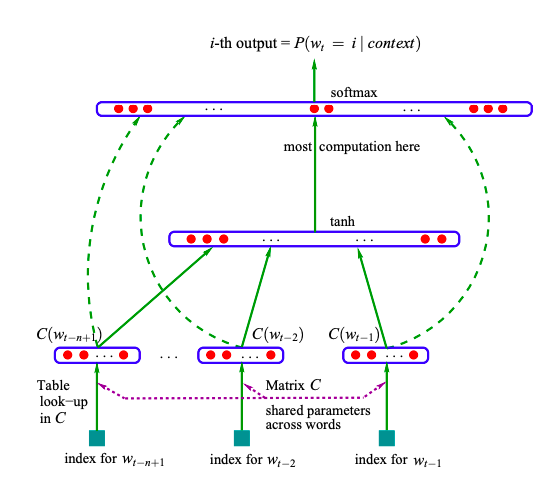

Com residual (bypass) conection:

y = b+Wx+U tanh(d +Hx)


In [112]:
class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, context_size, embedding_dim, hidden_size, se_projecao_direta:bool=False, verbose=False):
      """
      Implements the Neural Language Model proposed by Bengio et al."
      Sem operação residual

      Args:
          vocab_size (int): Size of the input vocabulary.
          context_size (int): Size of the sequence to consider as context for prediction.
          embedding_dim (int): Dimension of the embedding layer for each word in the context.
          hidden_size (int): Size of the hidden layer.
      
      Fonte apoio:
        https://abhinavcreed13.github.io/blog/bengio-trigram-nplm-using-pytorch/

      """
      # Escreva seu código aqui.
      assert isinstance(vocab_size,int), 'vocab_size deve ser do tipo int'      
      assert isinstance(context_size,int), 'context_size deve ser do tipo int'      
      assert isinstance(embedding_dim,int), 'embedding_dim deve ser do tipo int'      
      assert isinstance(hidden_size,int), 'hidden_size deve ser do tipo int'      
      super().__init__()
      self.context_size = context_size
      self.embedding_dim = embedding_dim
      self.vocab_size = vocab_size
      self.hidden_size = hidden_size
      self.verbose = verbose

      self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)     
      self.linear1 = nn.Linear(self.context_size * self.embedding_dim, self.hidden_size, bias=True)
      self.linear2 = nn.Linear(self.hidden_size, self.vocab_size, bias = True)
      self.se_projecao_direta = se_projecao_direta
      if self.se_projecao_direta:
        # Com residual (bypass) conection:
        # y = b+Wx+U tanh(d +Hx)
        self.projecao_direta = nn.Linear(self.context_size * self.embedding_dim, self.vocab_size, bias=True)


    def forward(self, inputs):
      """
      Args:
          inputs is a LongTensor of shape (batch_size, context_size)
      """
      # Escreva seu código aqui.
      # compute x': concatenation of x1 and x2 embeddings 
      assert inputs.shape[1] == self.context_size, f"Esperado inputs com {self.context_size} tokens"
      num_batchs = inputs.shape[0]
      if self.verbose:
        print(f"Entrou forward: inputs.shape = {inputs.shape}. Dim esperada num_batchs, context_size = ({num_batchs} , {self.context_size})")      
      embeds = self.embeddings(inputs).view((num_batchs,self.context_size * self.embedding_dim)) # BATCH_SIZE,  self.context_size * self.embedding_dim
      if self.verbose:
        print(f"Após self.embeddings: embeds.shape = {embeds.shape}. Dim esperada num_batchs, context_size * self.embedding_dim= ({num_batchs}, {self.embedding_dim * self.context_size})")      
      out = torch.tanh(self.linear1(embeds)) # BATCH_SIZE,  self.hidden_size
      if self.verbose:
        print(f"Após tang(linear1(embeds)): out.shape = {out.shape}. Dim esperada num_batchs, hidden_size = ({num_batchs} , {self.hidden_size})") 
      out = self.linear2(out) # BATCH_SIZE, vocab_size
      if self.verbose:
        print(f"Após linear2(out): out.shape = {out.shape}. Dim esperada num_batchs, vocab_size = ({num_batchs} , {self.vocab_size})")       
      if self.se_projecao_direta:
        proj_direta = self.projecao_direta(embeds) # BATCH_SIZE, vocab_size
        if self.verbose:
          print(f"Após projecao_direta(embeds): proj_direta.shape = {proj_direta.shape}. Dim esperada num_batchs, vocab_size = ({num_batchs} , {self.vocab_size})")       
        out += proj_direta # BATCH_SIZE, vocab_size
        if self.verbose:
          print(f"Após out += projecao_direta(embeds): out.shape = {out.shape}. Dim esperada num_batchs, vocab_size = ({num_batchs} , {self.vocab_size})")        

      # compute y: log_softmax
      log_probs = torch.nn.functional.softmax(out, dim=1) # BATCH_SIZE, vocab_size     
      if self.verbose:
        print(f"Após log_probs: log_probs.shape = {log_probs.shape}. Dim esperada num_batchs, vocab_size = ({num_batchs} , {self.vocab_size})")             
      if self.verbose:
        print(f"Soma log_probs", log_probs.sum(dim=1))
      return log_probs        


## Teste o modelo com um exemplo

In [48]:
hparam['vocab_size']=tokenizer.vocab_size
hparam['embedding_dim']=64
hparam['hidden_size']=128

#documentação
hparam['num_classes']=hparam['vocab_size']

hparam

{'batch_size': 50,
 'context_size': 9,
 'device': device(type='cuda', index=0),
 'early_stop': 4,
 'embedding_dim': 64,
 'hidden_size': 128,
 'learning_rate': 0.001,
 'num_classes': 29794,
 'num_sentenca_test': 10,
 'num_sentenca_train': 50,
 'num_sentenca_valid': 10,
 'num_workers_dataloader': 2,
 'test_size': 4297,
 'train_size': 32301,
 'valid_size': 25156,
 'vocab_size': 29794}

In [93]:
model = LanguageModel(
    vocab_size=hparam['vocab_size'],
    context_size=hparam['context_size'],
    embedding_dim=hparam['embedding_dim'],
    hidden_size=hparam['hidden_size'],
    se_projecao_direta=True,
    verbose=True
).to(device)


In [94]:
hparam['num_params'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of model parameters: {hparam['num_params']}")

Number of model parameters: 23015236


In [95]:
sample_train_x, sample_train_y = next(iter(DataLoader(training_dataset,batch_size=1)))
sample_train_x_gpu = sample_train_x.to(device)
print(f"sample_train_y.shape: {sample_train_y.shape}, sample_train_y: {sample_train_y}")
print(f"sample_train_x.shape: {sample_train_x.shape}, sample_train_x: {sample_train_x}")


sample_train_y.shape: torch.Size([1]), sample_train_y: tensor([13254])
sample_train_x.shape: torch.Size([1, 9]), sample_train_x: tensor([[20100,  2308,  3074,  1089,   481,   117,   146,  1189,   125]])


In [96]:
saida = model(sample_train_x_gpu)

Entrou forward: inputs.shape = torch.Size([1, 9]). Dim esperada num_batchs, context_size = (1 , 9)
Após self.embeddings: embeds.shape = torch.Size([1, 576]). Dim esperada num_batchs, context_size * self.embedding_dim= (1, 576)
Após tang(linear1(embeds)): out.shape = torch.Size([1, 128]). Dim esperada num_batchs, hidden_size = (1 , 128)
Após linear2(out): out.shape = torch.Size([1, 29794]). Dim esperada num_batchs, vocab_size = (1 , 29794)
Após projecao_direta(embeds): proj_direta.shape = torch.Size([1, 29794]). Dim esperada num_batchs, vocab_size = (1 , 29794)
Após out += projecao_direta(embeds): out.shape = torch.Size([1, 29794]). Dim esperada num_batchs, vocab_size = (1 , 29794)
Após log_probs: log_probs.shape = torch.Size([1, 29794]). Dim esperada num_batchs, vocab_size = (1 , 29794)
Soma log_probs tensor([1.0000], device='cuda:0', grad_fn=<SumBackward1>)


In [97]:
assert saida.shape[1] == hparam['vocab_size'], "Saída deveria ser do tamanho do vocabulário"

In [98]:
del saida

## Assert da Perplexidade


In [80]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)


def perplexity(logits, target):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, vocab_size)
        target: a LongTensor of shape (batch_size,)

    Returns:
        A float corresponding to the perplexity.
    """
    # Escreva seu código aqui.

    # calculando loss com cross entropy
    loss = torch.nn.functional.cross_entropy(logits, target)

    # calculando perplexidade 
    perplexidade  = torch.exp(loss)  
    return perplexidade


In [ ]:
n_examples = 1000
sample_train, target_token_ids = next(iter(DataLoader(training_dataset, batch_size=n_examples)))
sample_train_gpu = sample_train.to(device)
target_token_ids = target_token_ids.to(device)
logits = model(sample_train_gpu)


In [100]:
my_perplexity = perplexity(logits=logits, target=target_token_ids)

print(f'my perplexity:              {int(my_perplexity)}')
print(f'correct initial perplexity: {tokenizer.vocab_size}')


my perplexity:              29793
correct initial perplexity: 29794


In [101]:
assert math.isclose(my_perplexity, tokenizer.vocab_size, abs_tol=2000)
print('Passou o no assert da perplexidade')

Passou o no assert da perplexidade


# Laço de Treinamento e Validação

In [104]:

hparam['batch_size'] = 64
hparam['drop_last'] = True
train_loader = DataLoader(training_dataset, batch_size=hparam['batch_size'], shuffle=True, drop_last=hparam['drop_last'], num_workers=hparam['num_workers_dataloader'])
validation_loader = DataLoader(valid_dataset, batch_size=hparam['batch_size'], num_workers=hparam["num_workers_dataloader"])


In [127]:
hparam['max_examples'] = 1_000_000 # 100_000_000
hparam['eval_every_steps'] = 5000

hparam['criterion'] = torch.nn.functional.cross_entropy


In [128]:

model = LanguageModel(
    vocab_size=hparam['vocab_size'],
    context_size=hparam['context_size'],
    embedding_dim=hparam['embedding_dim'],
    hidden_size=hparam['hidden_size'],
    se_projecao_direta=False,
    verbose=False    
).to(device)


In [129]:
hparam['learning_rate'] = 1e-3
hparam['optimizer'] = torch.optim.Adam(model.parameters(), lr=hparam['learning_rate'])

## Funções auxiliares ao treinamento

In [130]:
def train_step(input, target):
    model.train()
    model.zero_grad()

    logits = model(input)
    loss = hparam['criterion'](logits, target)
    loss.backward()
    hparam['optimizer'].step()
    return loss.item()



In [131]:
def validation_step(input, target):
    model.eval()
    logits = model(input)
    loss = hparam['criterion'](logits, target)
    return loss.item()



## laço de treinamento

In [132]:
train_losses = []
n_examples = 0
step = 0
while n_examples < hparam['max_examples']:
    for input, target in train_loader:
        loss = train_step(input.to(device), target.to(device)) 
        train_losses.append(loss)
        
        if step % hparam['eval_every_steps'] == 0:
            train_ppl = np.exp(np.average(train_losses))

            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(input.to(device), target.to(device))
                    for input, target in validation_loader]))

            print(f'{step} steps; {n_examples} examples so far;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}; train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}')
            train_losses = []

        n_examples += len(input)  # Increment of batch size
        step += 1
        if n_examples >= hparam['max_examples']:
            break

0 steps; 0 examples so far;  Momento: [2022-May-16 13:47:23]; train ppl: 29794.02, valid ppl: 29794.01
5000 steps; 320000 examples so far;  Momento: [2022-May-16 13:47:53]; train ppl: 27339.42, valid ppl: 28359.50
10000 steps; 640000 examples so far;  Momento: [2022-May-16 13:48:23]; train ppl: 25615.07, valid ppl: 28451.50
15000 steps; 960000 examples so far;  Momento: [2022-May-16 13:48:53]; train ppl: 24421.48, valid ppl: 28515.80


## Avaliação final no dataset de teste


Bonus: o modelo com menor perplexidade no dataset de testes ganhará 0.5 ponto na nota final.

Perplexidade original em teste

In [133]:
test_loader = DataLoader(test_dataset, batch_size=hparam['batch_size'], num_workers=hparam["num_workers_dataloader"])

with torch.no_grad():
    test_ppl = np.exp(np.average([
        validation_step(input.to(device), target.to(device))
        for input, target in test_loader
    ]))

print(f'test perplexity: {test_ppl}')

test perplexity: 28667.25317967648


## Teste seu modelo com uma sentença

Escolha uma sentença gerada pelo modelo que ache interessante.

In [134]:
prompt = 'Eu gosto de comer pizza pois me faz'  # Ex: 'Eu gosto de comer pizza pois me faz'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-hparam["context_size"]:]
    logits = model(torch.LongTensor(input_ids_truncated).unsqueeze(0).to(device))    # nesse ponto unsqueeze transforma tensor(x) em tensor([x])  
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Eu gosto de comer pizza pois me faz se
Eu gosto de comer pizza pois me faz se,
Eu gosto de comer pizza pois me faz se, o
Eu gosto de comer pizza pois me faz se, o que
Eu gosto de comer pizza pois me faz se, o que do
Eu gosto de comer pizza pois me faz se, o que do o
Eu gosto de comer pizza pois me faz se, o que do o de
Eu gosto de comer pizza pois me faz se, o que do o de da
Eu gosto de comer pizza pois me faz se, o que do o de da a
Eu gosto de comer pizza pois me faz se, o que do o de da a,


# Rascunho

In [ ]:
raise Exception("Abaixo só rascunho - não cabe execuções fora de contexto ")

## Dataset

In [ ]:
lista_sentenca_numericalizada =  tokenize(dummy_texts, tokenizer)
type(lista_sentenca_numericalizada)

list

In [ ]:
lista_sentenca_numericalizada

[[3396, 10303, 125, 13239], [1660, 5971, 785, 125, 1847, 13779, 15616]]

In [ ]:
len(lista_sentenca_numericalizada)

2

In [ ]:
torch.Tensor(lista_sentenca_numericalizada)


ValueError: ignored

In [ ]:
 tensor_dtt=torch.LongTensor(dummy_texto_tokenizado[0])

In [ ]:
tensor_dtt


tensor([ 3396, 10303,   125, 13239])

In [ ]:
tensor_dtt[1:3]

tensor([10303,   125])

In [ ]:
dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, context_size=3)

In [ ]:
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False, num_workers=hparam["num_workers_dataloader")
assert len(dummy_dataset) == 5
print('passou no assert de tamanho do dataset')


passou no assert de tamanho do dataset


In [ ]:
first_batch_input, first_batch_target = next(iter(dummy_loader))


In [ ]:
first_batch_target


tensor([13239,   125,  1847, 13779, 15616])

In [ ]:
first_batch_input

tensor([[ 3396, 10303,   125],
        [ 1660,  5971,   785],
        [ 5971,   785,   125],
        [  785,   125,  1847],
        [  125,  1847, 13779]])

In [ ]:
t1 = torch.LongTensor([]) 
t1

tensor([], size=(1, 0), dtype=torch.int64)

In [ ]:
t2 = torch.LongTensor([ 3396, 10303,   125])
t2

tensor([ 3396, 10303,   125])

In [ ]:
t2.view(1, -1)

tensor([[ 3396, 10303,   125]])

In [ ]:
t2.reshape(1,-1)

tensor([[ 3396, 10303,   125]])

In [ ]:
t2.unsqueeze(0)

tensor([[ 3396, 10303,   125]])

In [ ]:
torch.LongTensor([t2])

ValueError: ignored

In [ ]:
torch.cat((t1, t2))

tensor([ 3396, 10303,   125])